In [1]:
####################################################################################################
# CR.Composite.ipynb
# Karl Lapo August/2015
####################################################################################################
# Composites of annual cycle, motivation for indexing 
####################################################################################################

# must insert this statement to render the plots within the notebook
# this is specific to the ipython notebook
%matplotlib inline

## Import statements
# netcdf/numpy/xray/stats
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xray
from scipy.stats.stats import pearsonr

# OS interaction
import sys, pickle, os

# import subplots function for plotting
import seaborn as sns
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap

# Solargeometry
import solargeo

## Directory listing
dir_data = '/Users/karllapo/gdrive/SnowHydrology/proj/CloudClimatology/data'
dir_print = '/Users/karllapo/gdrive/SnowHydrology/proj/CloudClimatology/Graphics'

# List of sub-directory names for each data set
dir_NLDAS = '/NLDAS'
dir_SYN = '/CERES_SYN'
dir_grobs = '/GroundObs'
dir_VIC = '/VIC_MTCLIM'
dir_WRF = '/WRF'
dir_AN = '/aeronet'

# Directory for basemap pickle files
dir_bmap = '/Users/karllapo/gdrive/SnowHydrology/proj/CloudClimatology/data/basemap'

In [2]:
####################################################################################################
# Functions
####################################################################################################

In [3]:
#### Function for combining xray data variables into a single array with new labeled dimension
def combinevars(ds_in,dat_vars,new_dim_name='new_dim',combinevarname='new_var'):
    ds_out = xray.Dataset()
    ds_out = xray.concat([ds_in[dv] for dv in dat_vars],dim='new_dim')
    ds_out = ds_out.rename({'new_dim': new_dim_name})
    ds_out.coords[new_dim_name] = dat_vars
    ds_out.name = combinevarname

    return ds_out

In [4]:
####################################################################################################
# Format Data
####################################################################################################

In [16]:
##### Load daily data

###########
## NLDAS ##
os.chdir(dir_data+dir_NLDAS)
nldas = xray.open_dataset('CA.NLDAS.irrad.daily.nc')
nldas = nldas.rename({'DLWRF_110_SFC':'LWdwn','DSWRF_110_SFC':'SWdwn'})
nldas.SWdwn.values[nldas.SWdwn.values > 2000] = np.nan

#########
## SYN ##
os.chdir(dir_data+dir_SYN)
syn = xray.open_dataset('CA.syn.irrad.daily.nc')
############ No flipping -- SYN reformatted on 08/20/15 for CR.Composite. OTHER SCRIPTS WILL NEED THIS FIX

#########
## VIC ##
os.chdir(dir_data+dir_VIC)
mtclim = xray.open_dataset('CA.MTCLIM.irrad.daily.nc')

#########
## WRF ##
os.chdir(dir_data+dir_WRF)
wrf = xray.open_dataset('CA.WRF.irrad.daily.nc')
wrf = wrf.rename({'lon':'longitude','lat':'latitude'})

In [19]:
##### Process daily ground observations
os.chdir(dir_data+dir_grobs)
grobs = xray.open_dataset('CA.grobs_combined.daily.xray.nc')
grobs = grobs.resample(freq='D', dim='time', how='mean')
grobs.SWdwn.values[grobs.SWdwn.values == 0] = np.nan
grobs = grobs.rename({'lon':'longitude','lat':'latitude'})
grobs.longitude.values = -grobs.longitude.values

## Remove stations outside study domain
# Bounding box - ragged domain
LL_rag = [-120,34.5]
LR_rag = [-115,34.5]
UR_rag = [-118.5,41]
UL_rag = [-123.5,41]

# Station lat/lon
stat_lat = grobs.latitude.values
stat_lon = grobs.longitude.values

# Ragged domain, CA study area
line_west_m = (UL_rag[1]-LL_rag[1])/(UL_rag[0]-LL_rag[0])
line_west_b = LL_rag[1]-line_west_m*LL_rag[0]
line_east_m = (UR_rag[1]-LR_rag[1])/(UR_rag[0]-LR_rag[0])
line_east_b = LR_rag[1]-line_east_m*LR_rag[0]
ind = np.nonzero((stat_lon > (stat_lat -line_west_b)/line_west_m) & \
                (stat_lon < (stat_lat-line_east_b)/line_east_m) & \
                (stat_lat > LR_rag[1]) & (stat_lat < UL_rag[1]))
# Reindex
stat_to_keep = grobs.station[ind]
grobs = grobs.reindex(station=stat_to_keep)

## Append station group information
# Station data excel speadsheet
stdat = pd.read_csv('All_StationSummary.v2.csv',sep= ',', \
                index_col=0,na_values=[-9999,'NaN']) # Read the supporting information
# station data -> xray structure
stdat = xray.Dataset(coords={'station': (['station'], stdat.index), \
                             'Grouping': (['station'],  stdat.Grouping)})    
# Merge into ground observation structure
grobs = grobs.merge(stdat,join='inner')
grobs = grobs.rename({'SWdwn':'grobs'})


In [20]:
#### Combine
## List w/ all irradiance datasets
daily_mean = {}
daily_mean['syn'] = syn
daily_mean['nldas'] = nldas
daily_mean['mtclim'] = mtclim
daily_mean['wrf'] = wrf
daily_mean['grobs'] = grobs

## Names
# Product names
pr_names = ['mtclim','nldas','syn','wrf']
num_products = np.size(pr_names)
grouping = ['north cv','south cv','west of crest','foothills','east of crest']

In [21]:
####################################################
## Find grid point containing each ground station ##
####################################################
# Station lat and lon
lon_stat = grobs.longitude.values
lat_stat = grobs.latitude.values

for pr in pr_names:        
    if pr == 'grobs':
        continue
    # lat/lon for product
    lon_rad = daily_mean[pr].longitude.values
    lat_rad = daily_mean[pr].latitude.values  
    # mesh
    lonm, latm = np.meshgrid(lon_rad,lat_rad)
    
    # Empty numpy array
    to_merge = np.empty((daily_mean[pr].time.size,grobs.station.size))
    
    ## Product values in each grid containing station
    for stat in grobs.station.values:
        
        # Station index
        stat_ind = np.where(stat == grobs.station.values)
        # Distance to product grid lat-lon
        d = (latm-lat_stat[stat_ind])**2 + (lonm-lon_stat[stat_ind])**2
        # Index of closest product grid
        dind = np.where(d==np.amin(d))
        # Grad grid values at the station, put into xray dataset
        if (daily_mean[pr].SWdwn.values[:,dind[0][0],dind[1][0]] == 0).all() \
                | np.isnan(daily_mean[pr].SWdwn.values[:,dind[0][0],dind[1][0]]).all():
            to_merge[:,stat_ind[0]] = daily_mean[pr].SWdwn.values[:,dind[0][0]+1,dind[1][0],np.newaxis]
        else:
            to_merge[:,stat_ind[0]] = daily_mean[pr].SWdwn.values[:,dind[0][0],dind[1][0],np.newaxis]
    
    ## Merge products w/ grobs xray structure
    to_merge_ds = xray.Dataset({pr:(('time','station'),to_merge), \
                                    'time':daily_mean[pr].time.values,\
                                    'station':grobs.station.values})
    grobs = grobs.merge(to_merge_ds)

In [26]:
#### Elevation Angle
d = pd.to_datetime(grobs.time.values)
el = xray.Dataset()
for stat in grobs.station.values:
    el[stat] = (('time'),solargeo.AVG_EL(d,\
                     grobs.loc[{'station':stat}].latitude.values,\
                     grobs.loc[{'station':stat}].longitude.values,\
                     0,'END'))
el = combinevars(el,el.data_vars,new_dim_name='station',combinevarname='el')
el.coords['time'] = d

# Add to xray Dataset
grobs['el'] = (('station','time'),el)

In [10]:
print(grobs)

<xray.Dataset>
Dimensions:    (station: 73, time: 5753)
Coordinates:
    network    (station) |S9 'CIMIS_IPM' 'CIMIS_IPM' 'CIMIS_IPM' 'CDWR' ...
  * station    (station) object 'Alpaugh' 'ARVIN' 'Auburn' 'bee' 'BISHOP' ...
    longitude  (station) float64 -119.5 -118.8 -121.1 -118.3 -118.4 -120.0 ...
    elev       (station) float64 64.0 152.0 285.0 2.768e+03 1.271e+03 215.0 ...
    latitude   (station) float64 35.87 35.2 38.88 37.53 37.35 35.65 37.93 ...
  * time       (time) datetime64[ns] 2000-01-01 2000-01-02 2000-01-03 ...
    Grouping   (station) object 'south cv' 'foothills' 'foothills' ...
Data variables:
    grobs      (time, station) float64 nan nan nan nan nan nan nan nan nan ...
    mtclim     (time, station) float64 113.1 69.73 94.44 114.6 113.9 110.2 ...
    nldas      (time, station) float64 nan nan nan nan nan nan nan nan nan ...
    syn        (time, station) float64 nan nan nan nan nan nan nan nan nan ...
    wrf        (time, station) float64 nan nan nan nan nan nan 

In [22]:
####################################################################################################
# Composites
####################################################################################################

In [23]:
#### General attributes
## Plotting set-up
colsche =   np.array([[51.,34.,138.],\
            [136.,204.,238.],\
            [17.,119.,71.],\
            [221.,204.,119.],\
            [204.,102.,119.]])
colsche = np.divide(colsche,256.)

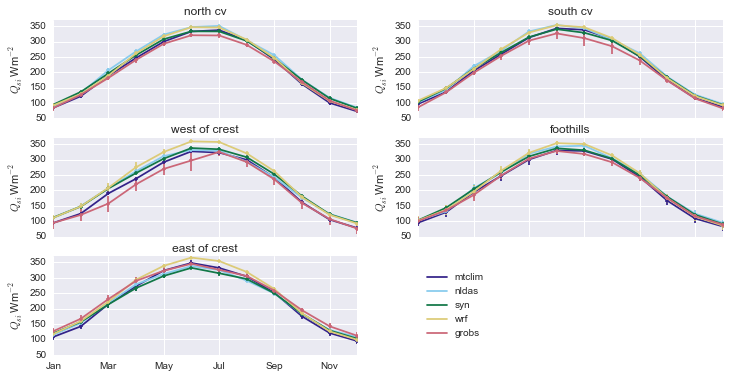

In [24]:
#### Monthly composite of annual cycle (Qsi)
f,axes = plt.subplots(3,2,sharex=True,figsize=(12,6))
pr_names_plot = ['mtclim','nldas','syn','wrf','grobs']
month_label = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

for ax,gr in zip(axes.flatten(),grouping):
    for n,pr in enumerate(pr_names_plot):
        month_comp = grobs[pr].groupby('time.month').mean('time')
        month_comp_mean = month_comp.swap_dims({'station':'Grouping'}).loc[{'Grouping':gr}].mean('Grouping')
        month_comp_std = month_comp.swap_dims({'station':'Grouping'}).loc[{'Grouping':gr}].std('Grouping')
        ax.plot(month_comp_mean,label=pr,color=colsche[n])
        ax.errorbar(np.arange(0,12),month_comp_mean,yerr=month_comp_std,color=colsche[n],fmt='.')
    
    ax.set_xlim(0,11)
    ax.set_ylim(50,370)
    ax.set_xticklabels(month_label[::2])
    ax.set_title(gr)
    ax.set_ylabel('$Q_{si}$ Wm$^{-2}$')
    if ax == axes.flatten()[0]:
        handles, labels = ax.get_legend_handles_labels()
        axes[-1,-1].axis('off')
        axes[-1,-1].legend(handles, labels,loc='center left')


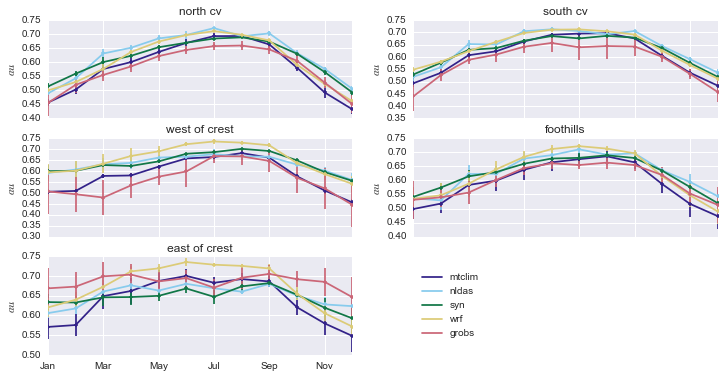

In [27]:
#### Monthly composite of annual cycle (Tau)
f,axes = plt.subplots(3,2,sharex=True,figsize=(12,6))
pr_names_plot = ['mtclim','nldas','syn','wrf','grobs']
month_label = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
tau = grobs/(np.sin(grobs.el*np.pi/180)*1365)

for ax,gr in zip(axes.flatten(),grouping):
    for n,pr in enumerate(pr_names_plot):
        month_comp = tau[pr].groupby('time.month').mean('time')
        month_comp_mean = month_comp.swap_dims({'station':'Grouping'}).loc[{'Grouping':gr}].mean('Grouping')
        month_comp_std = month_comp.swap_dims({'station':'Grouping'}).loc[{'Grouping':gr}].std('Grouping')
        ax.plot(month_comp_mean,label=pr,color=colsche[n])
        ax.errorbar(np.arange(0,12),month_comp_mean,yerr=month_comp_std,color=colsche[n],fmt='.')
    
    ax.set_xlim(0,11)
#     ax.set_ylim(50,370)
    ax.set_xticklabels(month_label[::2])
    ax.set_title(gr)
    ax.set_ylabel('$\tau$')
    if ax == axes.flatten()[0]:
        handles, labels = ax.get_legend_handles_labels()
        axes[-1,-1].axis('off')
        axes[-1,-1].legend(handles, labels,loc='center left')


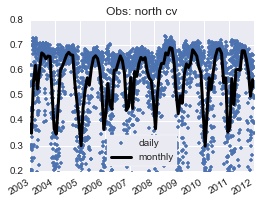

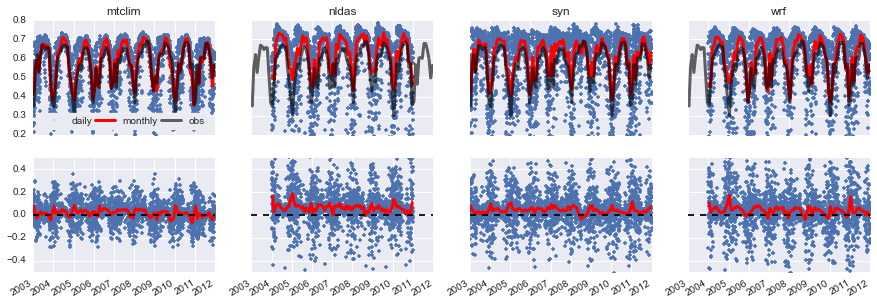

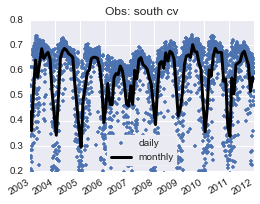

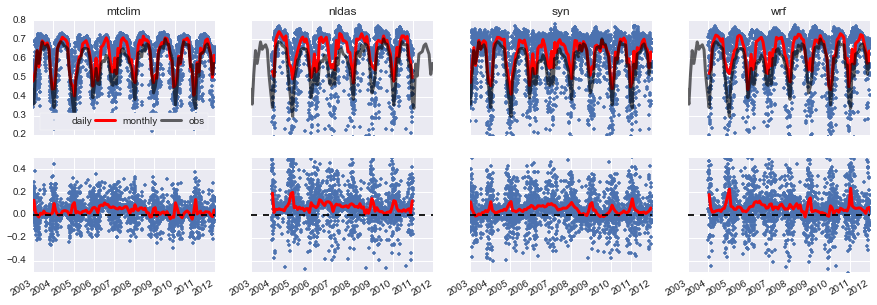

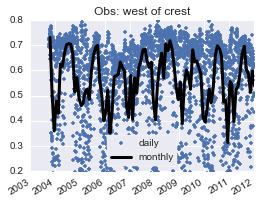

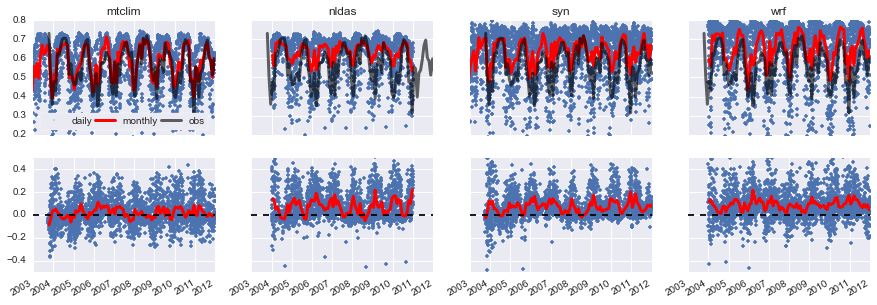

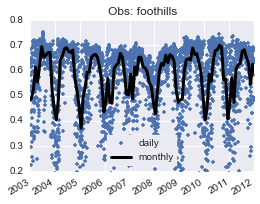

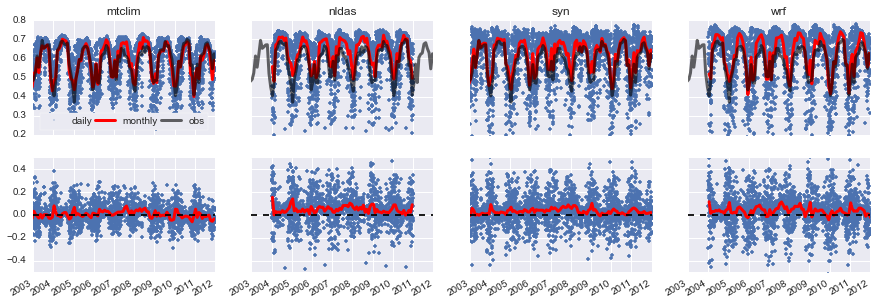

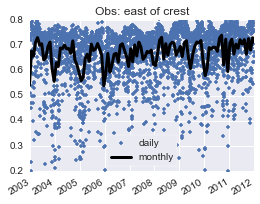

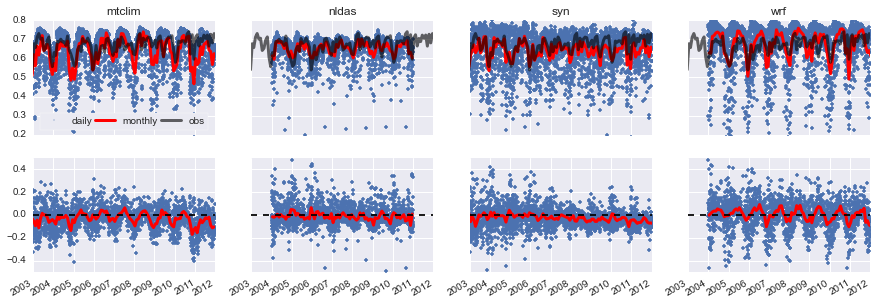

In [28]:
#### Time series: transmissivity
# Transmissivity
tau = grobs.grobs/(np.sin(grobs.el*np.pi/180)*1365)

## Transmissivity by group
for gr in grouping:
    ## tau for ground observations
    f = plt.figure(figsize=(4,3))
    tau_grobs = tau.swap_dims({'station':'Grouping'}).loc[{'Grouping':gr}].mean('Grouping')

    plt.plot(tau_grobs.time,tau_grobs,'.',label='daily')
    plt.plot(tau_grobs.resample(freq='M',dim='time',how='mean').time-pd.Timedelta(days=15),\
             tau_grobs.resample(freq='M',dim='time',how='mean'),'k',linewidth=3,label='monthly')

    ax = plt.gca()
    ax.set_title('Obs: '+gr)
    ax.set_ylim(.2,.8)
    ax.set_xlim(datetime(2003,1,1),datetime(2012,1,1))
    ax.legend(frameon=True,loc='best')
    f.autofmt_xdate()
    
    ## transmissivity of products
    f, axes = plt.subplots(2, num_products, figsize=(15,5),sharex='col', sharey='row')
    f.autofmt_xdate()
    for n,pr in enumerate(pr_names):
        # Mean transmissivity
        tau_pr = grobs[pr]/(np.sin(grobs.el*np.pi/180)*1365)
        tau_plot = tau_pr.swap_dims({'station':'Grouping'}).loc[{'Grouping':gr}].mean('Grouping')
        
        ax = axes[0,n]
        ax.plot(tau_pr.time,tau_plot,'.',label='daily')
        ax.plot(tau_plot.resample(freq='M',dim='time',how='mean').time-pd.Timedelta(days=15),\
                tau_plot.resample(freq='M',dim='time',how='mean').values,\
                'r',linewidth=3,label='monthly')
        ax.plot(tau.resample(freq='M',dim='time',how='mean').time-pd.Timedelta(days=15),\
             tau_grobs.resample(freq='M',dim='time',how='mean'),'k',linewidth=3,label='obs',alpha=.6)

        ax.set_ylim(.2,.8)
        ax.set_xlim(datetime(2003,1,1),datetime(2012,1,1))
        ax.set_title(pr)
        if ax == axes[0,0]:
            ax.legend(loc='lower center',ncol=3,frameon=True,markerscale=.3,columnspacing=.3,)

        # Difference from observed tau
        tau_diff = tau_plot-tau_grobs

        ax = axes[1,n]
        ax.plot(tau_diff.time,tau_diff,'.',label='daily')
        ax.plot(tau_diff.resample(freq='M',dim='time',how='mean').time-pd.Timedelta(days=15),\
                tau_diff.resample(freq='M',dim='time',how='mean').values,\
                'r',linewidth=3,label='monthly')
        ax.plot(np.array((datetime(2003,1,1),datetime(2012,1,1))),np.array((0,0)),'k--')

        ax.set_ylim(-.5,.5)
        ax.set_xlim(datetime(2003,1,1),datetime(2012,1,1))

In [ ]:
#### Time series: Mean group value, number of observations, anomaly
## Function for creating monthly group anomaly
def mon_anom(xray_df,gr):
    # Group monthly composite
    
    # Group monthly mean
    
    # Group monthly anomaly
    
    
    tau_grobs = tau.swap_dims({'station':'Grouping'}).loc[{'Grouping':gr}].mean('Grouping')
    # Monthly anomaly maps
    df_anom = xray_df.groupby('time.month')-df_cl

    # Return anomaly/index
    return(anomaly)

#### Time series: transmissivity
# Transmissivity
tau = grobs.grobs/(np.sin(grobs.el*np.pi/180)*1365)

## Transmissivity by group
for gr in grouping:
    ## tau for ground observations
    f = plt.figure(figsize=(4,3))

    plt.plot(tau_grobs.time,tau_grobs,'.',label='daily')
    plt.plot(tau_grobs.resample(freq='M',dim='time',how='mean').time-pd.Timedelta(days=15),\
             tau_grobs.resample(freq='M',dim='time',how='mean'),'k',linewidth=3,label='monthly')

    ax = plt.gca()
    ax.set_title('Obs: '+gr)
    ax.set_ylim(.2,.8)
    ax.set_xlim(datetime(2003,1,1),datetime(2012,1,1))
    ax.legend(frameon=True,loc='best')
    f.autofmt_xdate()
    
    ## transmissivity of products
    f, axes = plt.subplots(2, num_products, figsize=(15,5),sharex='col', sharey='row')
    f.autofmt_xdate()
    for n,pr in enumerate(pr_names):
        # Mean transmissivity
        tau_pr = grobs[pr]/(np.sin(grobs.el*np.pi/180)*1365)
        tau_plot = tau_pr.swap_dims({'station':'Grouping'}).loc[{'Grouping':gr}].mean('Grouping')
        
        ax = axes[0,n]
        ax.plot(tau_pr.time,tau_plot,'.',label='daily')
        ax.plot(tau_plot.resample(freq='M',dim='time',how='mean').time-pd.Timedelta(days=15),\
                tau_plot.resample(freq='M',dim='time',how='mean').values,\
                'r',linewidth=3,label='monthly')
        ax.plot(tau.resample(freq='M',dim='time',how='mean').time-pd.Timedelta(days=15),\
             tau_grobs.resample(freq='M',dim='time',how='mean'),'k',linewidth=3,label='obs',alpha=.6)

        ax.set_ylim(.2,.8)
        ax.set_xlim(datetime(2003,1,1),datetime(2012,1,1))
        ax.set_title(pr)
        if ax == axes[0,0]:
            ax.legend(loc='lower center',ncol=3,frameon=True,markerscale=.3,columnspacing=.3,)

        # Difference from observed tau
        tau_diff = tau_plot-tau_grobs

        ax = axes[1,n]
        ax.plot(tau_diff.time,tau_diff,'.',label='daily')
        ax.plot(tau_diff.resample(freq='M',dim='time',how='mean').time-pd.Timedelta(days=15),\
                tau_diff.resample(freq='M',dim='time',how='mean').values,\
                'r',linewidth=3,label='monthly')
        ax.plot(np.array((datetime(2003,1,1),datetime(2012,1,1))),np.array((0,0)),'k--')

        ax.set_ylim(-.5,.5)
        ax.set_xlim(datetime(2003,1,1),datetime(2012,1,1))



In [ ]:
#####################################
## Time series of bias by Grouping ##
#####################################
# formating preface
# grouping = ['north cv','south cv','west of crest','foothills','east of crest']
grouping = ['north cv','south cv']
colsche =   np.array([[51.,34.,138.],\
            [136.,204.,238.],\
            [17.,119.,71.],\
            [221.,204.,119.],\
            [204.,102.,119.]])
colsche = np.divide(colsche,256.)
fig = plt.figure(figsize=(12,12))
gs = matplotlib.gridspec.GridSpec(2,3,width_ratios=[12,12,12],height_ratios=[12,12,12])
for n,pr in enumerate(pr_names):
    print(pr)
    
    if pr == 'grobs':
        continue
    ax = plt.subplot(gs[0,n-1])
    plt.plot(np.array([datetime(2002,1,1),datetime(2013,1,1)]),np.array([0,0]),'k--')
    grobs_diff = (grobs[pr]-grobs.SWdwn)
    grobs_diff = grobs_diff.swap_dims({'station':'Grouping'})
    
    # Buid dataset
    for m,gr in enumerate(grouping):
        plt.plot(grobs_diff.time,grobs_diff.loc[{'Grouping':gr}].mean(dim='Grouping'),color=colsche[m],label=gr)
    
    # Labels and legend
    if n == 1:
        ax.legend(ncol=1,labelspacing=.25,markerscale=2,numpoints=1,columnspacing=.3,frameon=True)   
        ax.set_ylabel('Bias')
    ax.set_xlim(datetime(2002,1,1),datetime(2013,1,1))
    ax.set_ylim(-150,150)
    plt.plot(np.array([datetime(2002,1,1),datetime(2013,1,1)]),np.array([0,0]),'k--')

    ax = plt.subplot(gs[1,n-1])
    plt.plot(aod.index.values,aod.values)
    ax.set_xlim(datetime(2002,1,1),datetime(2013,1,1))
    
os.chdir(dir_print)
fname = 'SWdwn_bias_monthly.groups.png'
fig.savefig(fname)


In [ ]:
#####################################
## Time series of bias by Grouping ##
#####################################
from scipy.stats.stats import pearsonr

# formating preface
# grouping = ['north cv','south cv','west of crest','foothills','east of crest']
pr_names = ['grobs','syn','mtclim']
grouping = ['north cv','south cv']
colsche =   np.array([[51.,34.,138.],\
            [136.,204.,238.],\
            [17.,119.,71.],\
            [221.,204.,119.],\
            [204.,102.,119.]])
colsche = np.divide(colsche,256.)
fig = plt.figure(figsize=(12,12))
gs = matplotlib.gridspec.GridSpec(1,3,width_ratios=[12,12,12],height_ratios=[3,3,3])
for n,pr in enumerate(pr_names):
    print(pr)
    
    if pr == 'grobs':
        continue
    ax = plt.subplot(gs[0,n-1])
    plt.plot(np.array([datetime(2002,1,1),datetime(2013,1,1)]),np.array([0,0]),'k--')
    grobs_diff = (grobs[pr]-grobs.SWdwn)
#     grobs_diff = grobs_diff.swap_dims({'station':'Grouping'})
    
    # Buid dataset
#     for m,gr in enumerate(grouping):
    plt.plot(grobs_diff.time,grobs_diff.loc[{'station':'FRESNO'}].values,label='FRESNO')
    
    # Labels and legend
    if n == 1:
        ax.legend(ncol=1,labelspacing=.25,markerscale=2,numpoints=1,columnspacing=.3,frameon=True)   
        ax.set_ylabel('Bias (model - obs)')
    ax.set_xlim(datetime(2002,1,1),datetime(2013,1,1))
    ax.set_ylim(-150,150)
    plt.plot(np.array([datetime(2002,1,1),datetime(2013,1,1)]),np.array([0,0]),'k--')

    ax = plt.subplot(gs[0,2])
    plt.plot(aod.index.values,aod.values)
    ax.set_xlim(datetime(2002,1,1),datetime(2013,1,1))
    
    print('Stats for :'+pr)
    d1 = datetime(2004,1,1)
    d2 = datetime(2011,1,1)
    obs = grobs_diff.loc[{'station':'FRESNO'}]
    a = aod.reindex(obs.time.values,fill_value=np.nan)
    obs['aod'] = (['time'],a)
    obs = obs.loc[d1:d2]
#     print(obs)
#     a = aod.loc[d1:d2]
#     print(obs.values.shape)
#     print(a)
    print(pearsonr(obs.values[np.where(~np.isnan(obs.aod.values))],\\
                   obs.aod.values[np.where(~np.isnan(obs.aod.values))]))

In [ ]:
#####################################
## Time series of bias by Grouping ##
#####################################
from scipy.stats.stats import pearsonr
import solargeo

# formating preface
# grouping = ['north cv','south cv','west of crest','foothills','east of crest']
pr_names = ['grobs','syn','mtclim']
grouping = ['north cv','south cv']
colsche =   np.array([[51.,34.,138.],\
            [136.,204.,238.],\
            [17.,119.,71.],\
            [221.,204.,119.],\
            [204.,102.,119.]])
colsche = np.divide(colsche,256.)

# Dates
d1 = datetime(2004,1,1)
d2 = datetime(2010,9,1)
# Elevation angle
# el = solargeo.AVG_EL(grobs.loc[{'station':'FRESNO'}].time.values,\
#                      grobs.loc[{'station':'FRESNO'}].latitude.values,\
#                      grobs.loc[{'station':'FRESNO'}].longitude.values,\
#                      -8,'END')
for n,pr in enumerate(pr_names):
    print(pr)
    
    if pr == 'grobs':
        continue
#     ax = plt.subplot(gs[0,n-1])
#     plt.plot(np.array([datetime(2002,1,1),datetime(2013,1,1)]),np.array([0,0]),'k--')
    grobs_diff = (grobs[pr]-grobs.SWdwn)
#     grobs_diff = grobs_diff.swap_dims({'station':'Grouping'})
    
    # Buid dataset
    obs = grobs_diff.loc[{'station':'FRESNO'}]
    a = aod.reindex(obs.time.values,fill_value=np.nan)
    obs['aod'] = (['time'],a)
    obs = obs.loc[d1:d2]
    plt.figure()
    plt.plot(obs.aod.values,obs.values,'.',label='FRESNO')
    
    
for n,pr in enumerate(pr_names):
    print(pr)
    
#     ax = plt.subplot(gs[0,n-1])
#     plt.plot(np.array([datetime(2002,1,1),datetime(2013,1,1)]),np.array([0,0]),'k--')
#     grobs_diff = (grobs[pr]-grobs.SWdwn)
#     grobs_diff = grobs_diff.swap_dims({'station':'Grouping'})
    
    # Buid dataset
    if pr == 'grobs':
        obs = grobs.SWdwn.loc[{'station':'FRESNO'}]
    else:
        obs = grobs[pr].loc[{'station':'FRESNO'}]

    a = aod.reindex(obs.time.values,fill_value=np.nan)
    obs['aod'] = (['time'],a)
    obs = obs.loc[d1:d2]
    plt.figure()
    plt.plot(obs.aod.values,obs.values,'.',label='FRESNO')   
 

In [ ]:
#####################################
## Time series of bias by Grouping ##
#####################################
from scipy.stats.stats import pearsonr
import solargeo

# formating preface
# grouping = ['north cv','south cv','west of crest','foothills','east of crest']
pr_names = ['grobs','syn','mtclim']
grouping = ['north cv','south cv']
colsche =   np.array([[51.,34.,138.],\
            [136.,204.,238.],\
            [17.,119.,71.],\
            [221.,204.,119.],\
            [204.,102.,119.]])
colsche = np.divide(colsche,256.)

# Dates
d1 = datetime(2004,1,1)
d2 = datetime(2010,9,1)
# Elevation angle
# el = solargeo.AVG_EL(grobs.loc[{'station':'FRESNO'}].time.values,\
#                      grobs.loc[{'station':'FRESNO'}].latitude.values,\
#                      grobs.loc[{'station':'FRESNO'}].longitude.values,\
#                      -8,'END')
for n,pr in enumerate(pr_names):
    print(pr)
    
    if pr == 'grobs':
        continue
#     ax = plt.subplot(gs[0,n-1])
#     plt.plot(np.array([datetime(2002,1,1),datetime(2013,1,1)]),np.array([0,0]),'k--')
    grobs_diff = (grobs[pr]-grobs.SWdwn)
#     grobs_diff = grobs_diff.swap_dims({'station':'Grouping'})
    
    # Buid dataset
    obs = grobs_diff.loc[{'station':'FRESNO'}]
    a = aod.reindex(obs.time.values,fill_value=np.nan)
    obs['aod'] = (['time'],a)
    obs = obs.loc[d1:d2]
    plt.figure()
    plt.plot(obs.aod.values,obs.values,'.',label='FRESNO')
    
    
for n,pr in enumerate(pr_names):
    print(pr)
    
#     ax = plt.subplot(gs[0,n-1])
#     plt.plot(np.array([datetime(2002,1,1),datetime(2013,1,1)]),np.array([0,0]),'k--')
#     grobs_diff = (grobs[pr]-grobs.SWdwn)
#     grobs_diff = grobs_diff.swap_dims({'station':'Grouping'})
    
    # Buid dataset
    if pr == 'grobs':
        obs = grobs.SWdwn.loc[{'station':'FRESNO'}]
    else:
        obs = grobs[pr].loc[{'station':'FRESNO'}]

    a = aod.reindex(obs.time.values,fill_value=np.nan)
    obs['aod'] = (['time'],a)
    obs = obs.loc[d1:d2]
    plt.figure()
    plt.plot(obs.aod.values,obs.values,'.',label='FRESNO')   
 

In [ ]:
##### Quick test to make sure solargeo module is working as intended
# Mostly matches matlab output, but some discrepancies exist, values do not match exactly
import solargeo
d1 = datetime(2006,1,1)
d2 = datetime(2006,2,1)
# Elevation angle
pd_time = pd.to_datetime(grobs.time.values)
pd_dt = pd_time[1]-pd_time[0]

el = solargeo.AVG_EL(pd.to_datetime(grobs.time.values),\
                     grobs.loc[{'station':'FRESNO'}].latitude.values,\
                     grobs.loc[{'station':'FRESNO'}].longitude.values,\
                     0,'END')

plt.figure()
plt.plot(grobs.time.values,np.sin(el*np.pi/180)*1365)
plt.plot(grobs.time.values,grobs.SWdwn.loc[{'station':'FRESNO'}].values)

plt.figure()
ax = plt.gca()
plt.plot(grobs.time.values,el)
plt.plot(grobs.time.values,np.arcsin(grobs.SWdwn.loc[{'station':'FRESNO'}].values/1365)*180/np.pi)
ax.set_xlim([d1,d2])

plt.figure()
ax = plt.gca()
plt.plot(grobs.time.values,np.sin(el*np.pi/180)*1365)
plt.plot(grobs.time.values,grobs.SWdwn.loc[{'station':'FRESNO'}].values)
ax.set_xlim([d1,d2])